# Import Libraries & add paths


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("../") 

import LISA as l
import Glitch as gl

# Create an instance of LISA's orbit and a Wavelet Object

In [2]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt

Hour = 2.*3600.

mHz = 1.0e-3

print np.log2(Tobs/dt)

# set up the LISA orbit
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

print "Nyquist Freq........ {} mHz".format(orb.f_ny*1000.)

# set up parameters of wavelet
A    = 1.
f0   = 3.0*mHz
tau  = 1.*Hour
t0   = 0.5*orb.Tobs
phi0 = 0.

print "Q................... {}"  .format(np.pi*f0*tau)
print "tau................. {} s".format(tau)
print "dt.................. {} s".format(orb.dt)

wave = gl.Wavelet(A, f0, tau, t0, phi0, orb)
wave.calc_Psi()
wave.make_padded_Psi(t) # drop in the wavelet time series into the data stream
h = h + wave.Psi_padded

16.0
Nyquist Freq........ 33.3333333333 mHz
Q................... 67.8584013175
tau................. 7200.0 s
dt.................. 15.0 s


## Plot the Wavelet Object in the SSB, time domain

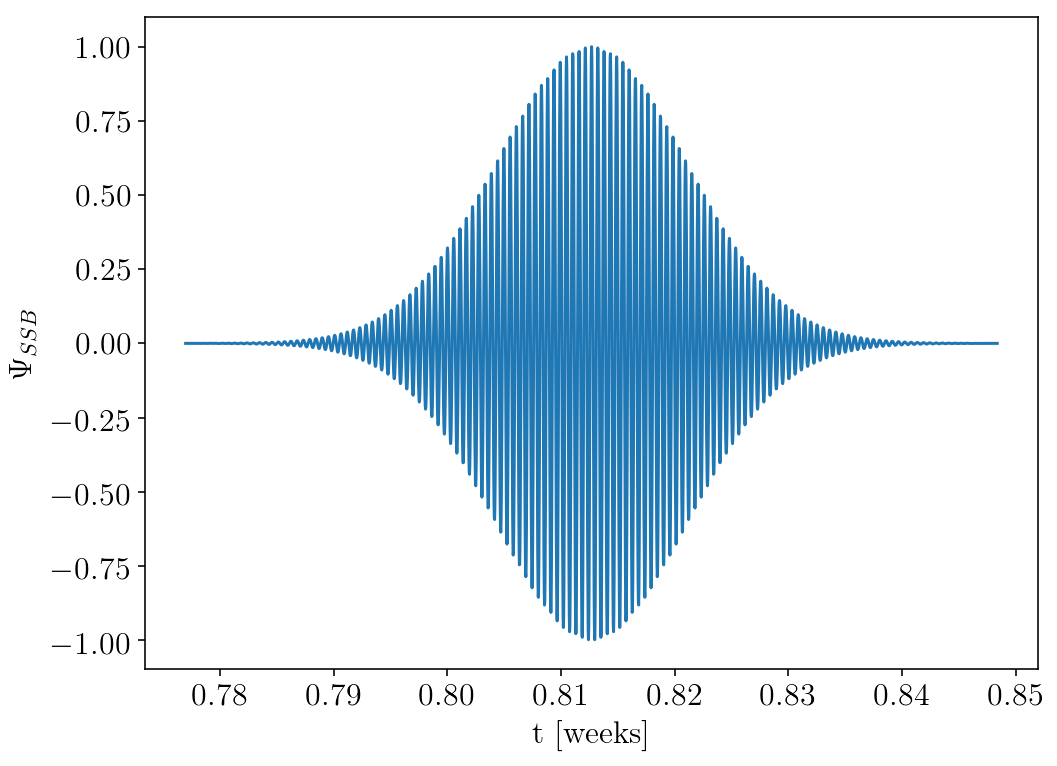

In [4]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [weeks]', fontsize=16)
ax.set_ylabel(r'$\Psi_{\text{SSB}}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(wave.t/Week, wave.Psi)

plt.show()

# Generate TDI for instrument glitch injection

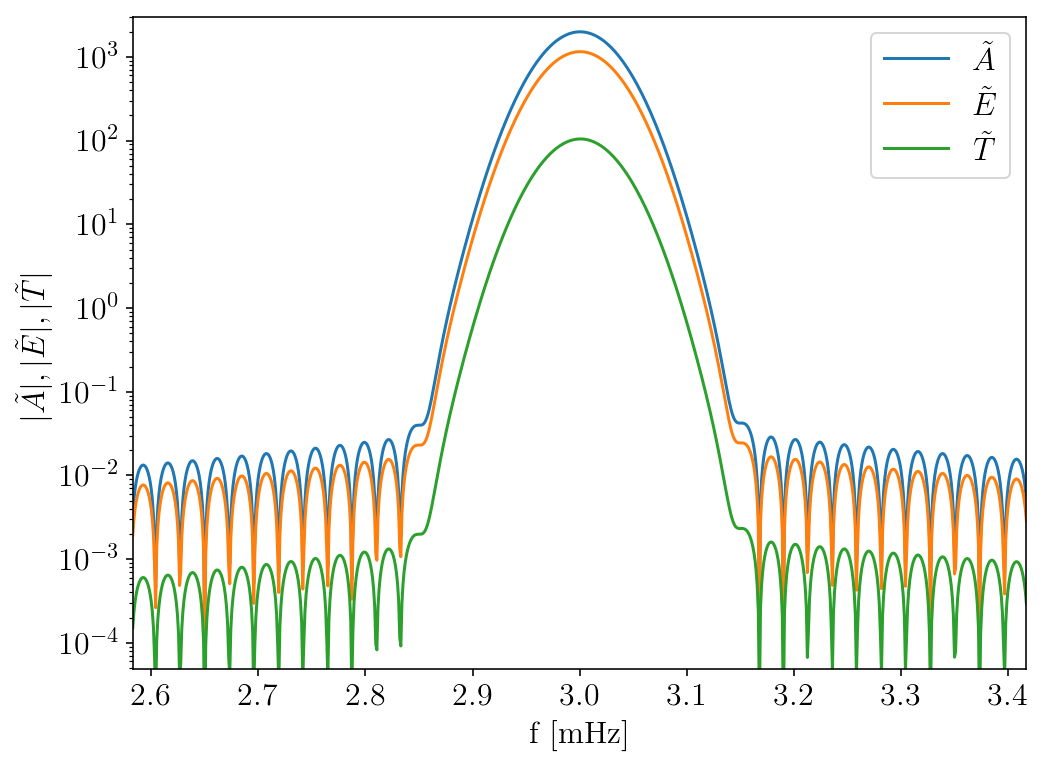

In [5]:
tdi = gl.create_instrument_glitch_TDI('Optical Path', 1, wave, orb, 2)
#tdi = gl.create_instrument_glitch_TDI('Laser Phase', 3, wave, orb, None)
# tdi = gl.create_instrument_glitch_TDI('Acceleration', 1, wave, orb, 3)

fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{A}|,|\tilde{E}|,|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

mask = (tdi.freqs > wave.f_min) & (tdi.freqs < wave.f_max) 

y_vals = []

if (len(np.abs(tdi.A)[(np.abs(tdi.A) != 0.0)]) != 0):
    y_vals.append(np.abs(tdi.A[mask]))
    ax.semilogy(tdi.freqs*mult, np.abs(tdi.A), label=r'$\tilde{A}$')
 
if (len(np.abs(tdi.E)[(np.abs(tdi.E) != 0.0)]) != 0):
    y_vals.append(np.abs(tdi.E[mask]))
    ax.semilogy(tdi.freqs*mult, np.abs(tdi.E), label=r'$\tilde{E}$')

if (len(np.abs(tdi.T)[(np.abs(tdi.T) != 0.0)]) != 0):
    y_vals.append(np.abs(tdi.E[mask]))
    ax.semilogy(tdi.freqs*mult, np.abs(tdi.T), label=r'$\tilde{T}$')

y_min = 0.5*np.min(y_vals)
y_max = 1.5*np.max(y_vals)

ax.set_ylim(y_min, y_max)
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

## Investigate the time domain signal

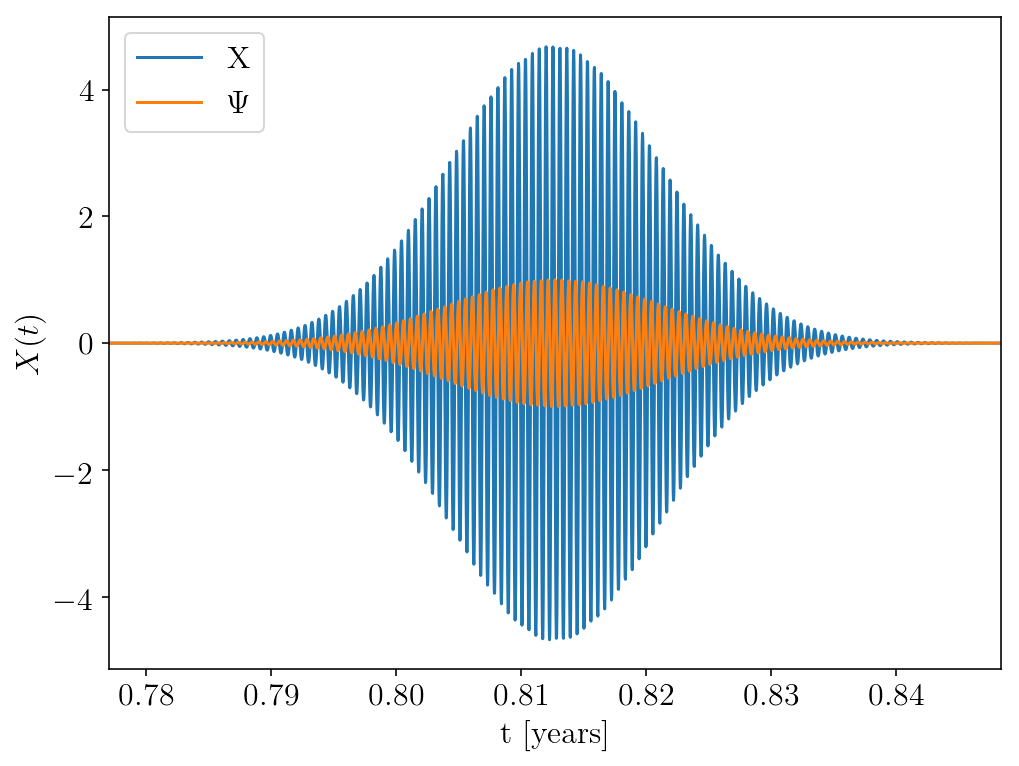

In [6]:
X_time_dom = np.fft.irfft(tdi.X)

fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'$X(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim((wave.t0 - 3.*wave.tau)/Week, (wave.t0 + 3.*wave.tau)/Week)

ax.plot(t[1:-1]/Week, X_time_dom, label=r'X')
ax.plot(wave.t/Week, wave.Psi, label=r'$\Psi$')


plt.legend(loc='upper left', fontsize=16)
plt.show()

# Setup second wavelet to be injected into cross polarization

Q................... 67.8584013175
tau................. 7200.0 s
dt.................. 15.0 s


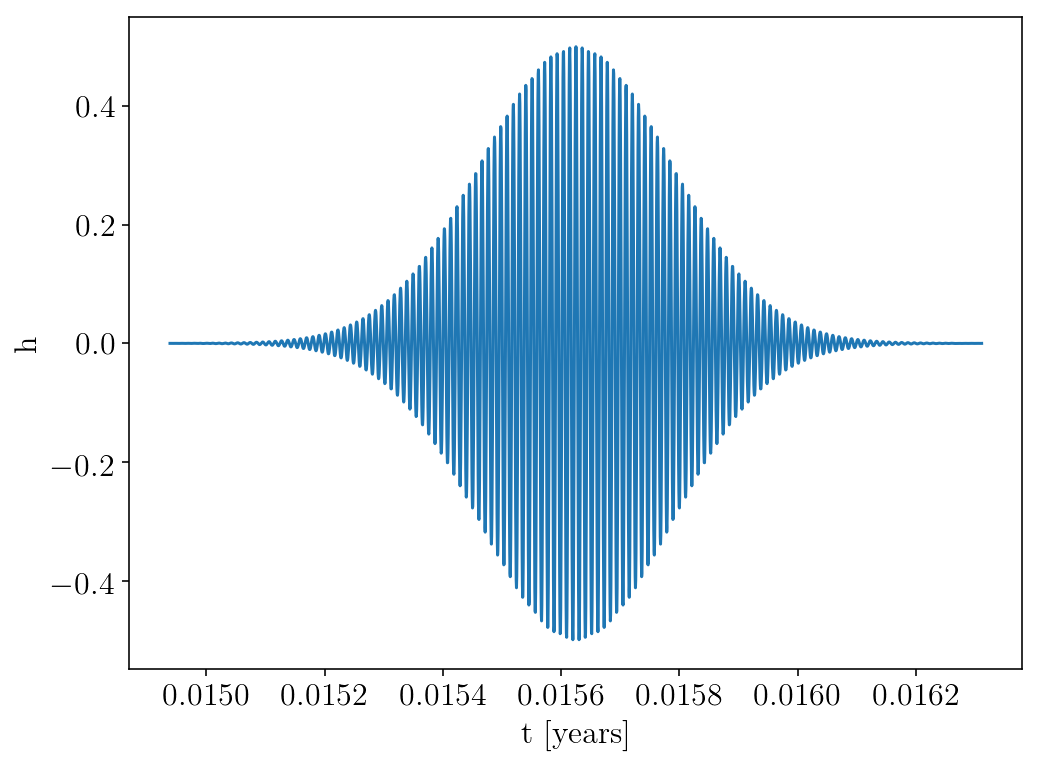

In [7]:
# set up parameters of wavelet
ep = 0.5 # polarization parameter

print "Q................... {}"  .format(np.pi*f0*tau)
print "tau................. {} s".format(tau)
print "dt.................. {} s".format(orb.dt)

wave2 = gl.Wavelet(ep*A, f0, tau, t0, phi0, orb)
wave2.calc_Psi()
wave2.make_padded_Psi(t)

# don't plot if I didn't inject anything into the second wavelet
mask = (wave2.Psi != 0.0)
if (len(wave2.Psi[mask]) != 0):
    fig, ax = plt.subplots(1, figsize=(8,6))

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    ax.set_xlabel(r't [years]', fontsize=16)
    ax.set_ylabel(r'h', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.plot(wave2.t/l.YEAR, wave2.Psi)

    plt.show()

# Construct Gravitational Wave Glitch


In [8]:
# sky angles and polarization angles.
phi   = np.pi*0.2
theta = np.pi*0.25
psi   = np.pi*0.23

gw = gl.GW_glitch(wave, wave2, theta, phi, psi, orb)
gw.construct_detector_tensor()
gw.calculate_strain()


In [10]:
gw.hp_wavelet.get_Psi(gw.xi[0])

array([  1.54051792e-04,   1.47563277e-04,   1.29024019e-04, ...,
        -9.07092724e-05,  -7.46909636e-05,  -5.32034129e-05])

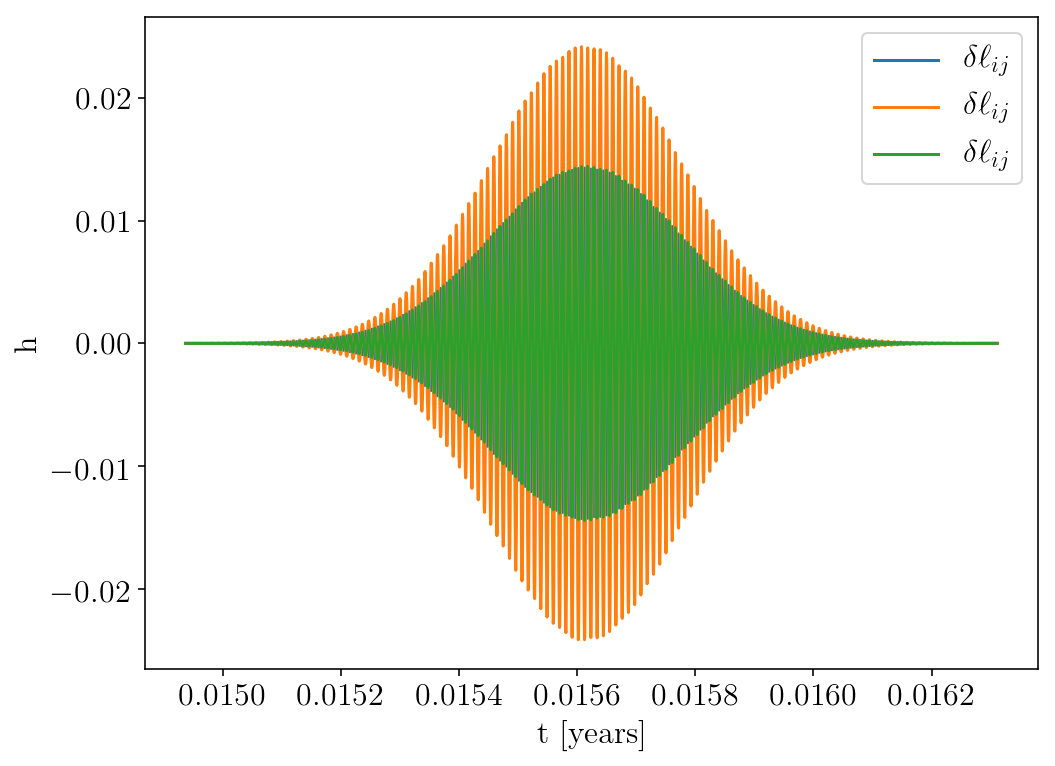

In [11]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(gw.t/l.YEAR, gw.delta_l[0,2], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[0,1], label=r'$\delta\ell_{ij}$')
ax.plot(gw.t/l.YEAR, gw.delta_l[1,2], label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper right', fontsize=16)

plt.show()

In [12]:
gw.make_padded_delta_l(t)

p12 = gl.Phase(1,2, t, gw.delta_l_padded[0,1,:])
p21 = gl.Phase(2,1, t, gw.delta_l_padded[1,0,:])

p13 = gl.Phase(1,3, t, gw.delta_l_padded[0,2,:])
p31 = gl.Phase(3,1, t, gw.delta_l_padded[2,0,:])

p23 = gl.Phase(2,3, t, gw.delta_l_padded[1,2,:])
p32 = gl.Phase(3,2, t, gw.delta_l_padded[2,1,:])
   
p12.FT_phase(orb)
p21.FT_phase(orb)
p13.FT_phase(orb)
p31.FT_phase(orb)
p23.FT_phase(orb)
p32.FT_phase(orb)

tdi_GW = gl.TDI(p12, p21, p13, p31, p23, p32, orb)

In [13]:
noise = np.fft.irfft(tdi_GW.X)

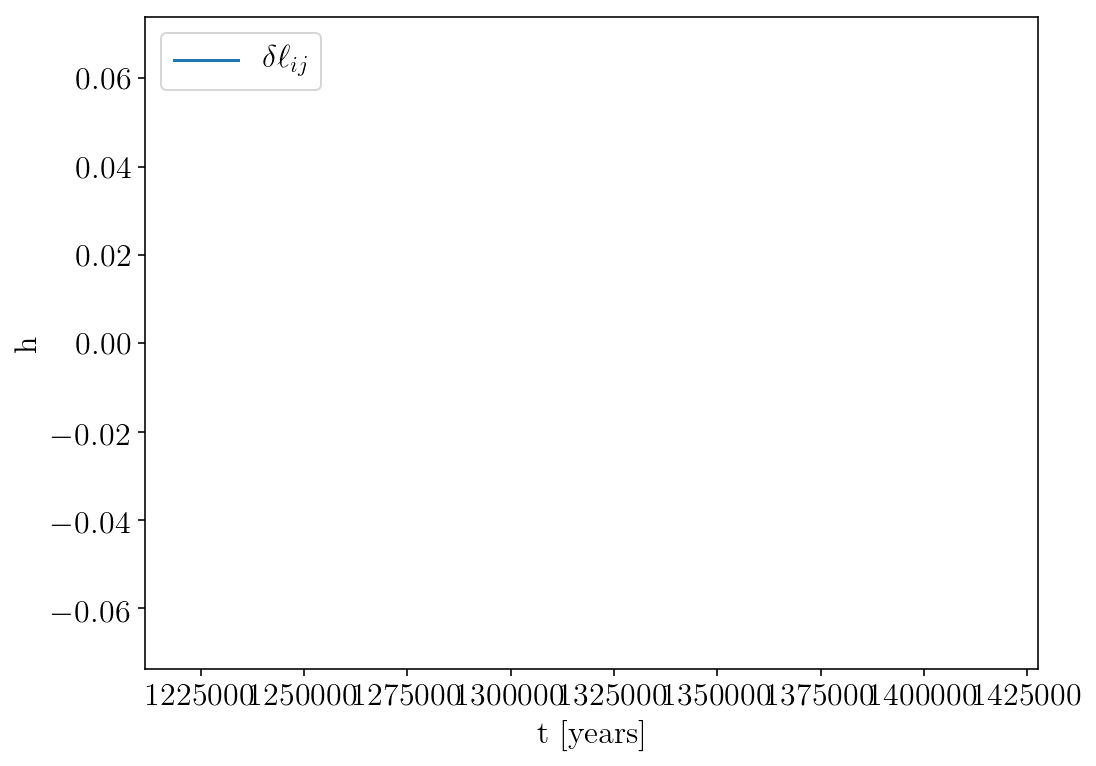

In [14]:
fig, ax = plt.subplots(1, figsize=(8,6))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlabel(r't [years]', fontsize=16)
ax.set_ylabel(r'h', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

#plt.xlim((wave.t0 + 100.*wave.tau)/l.YEAR, (wave.t0 + 130.*wave.tau)/l.YEAR)
plt.xlim((wave.t0 + 100.*wave.tau), (wave.t0 + 130.*wave.tau))



ax.plot(t[1:-1], noise.real, label=r'$\delta\ell_{ij}$')

ax.legend(loc='upper left', fontsize=16)



plt.show()

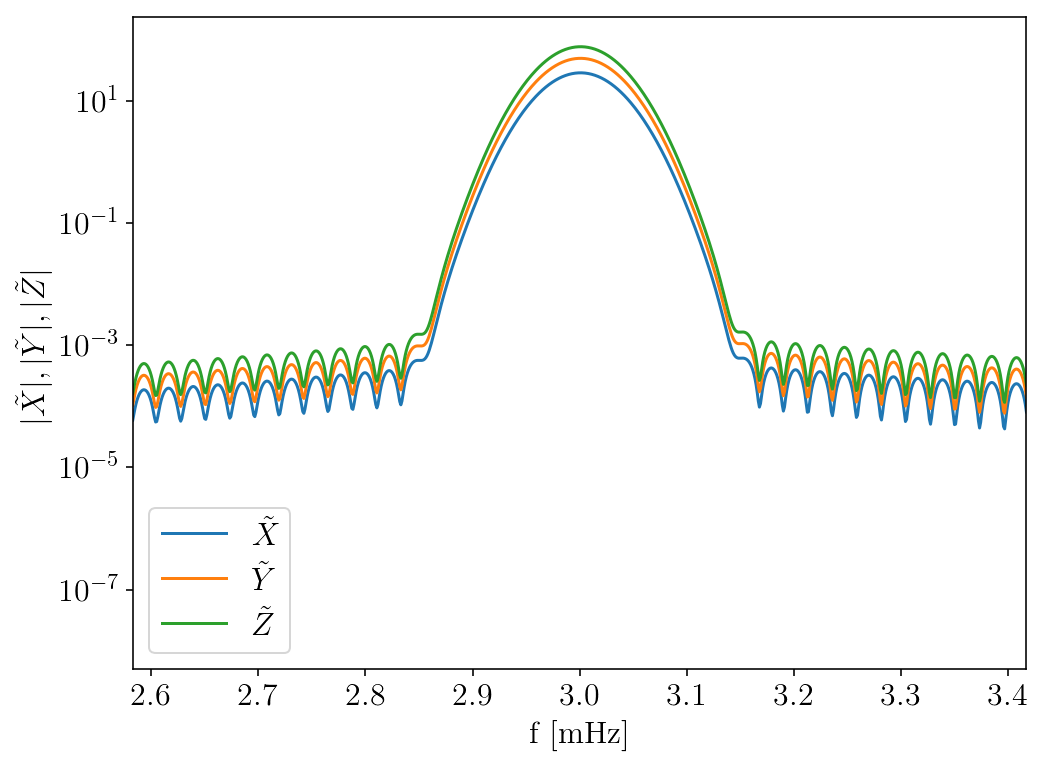

In [15]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{X}|,|\tilde{Y}|,|\tilde{Z}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'$\tilde{X}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Y), label=r'$\tilde{Y}$')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.Z), label=r'$\tilde{Z}$')

plt.legend(loc='lower left', fontsize=16)

plt.show()

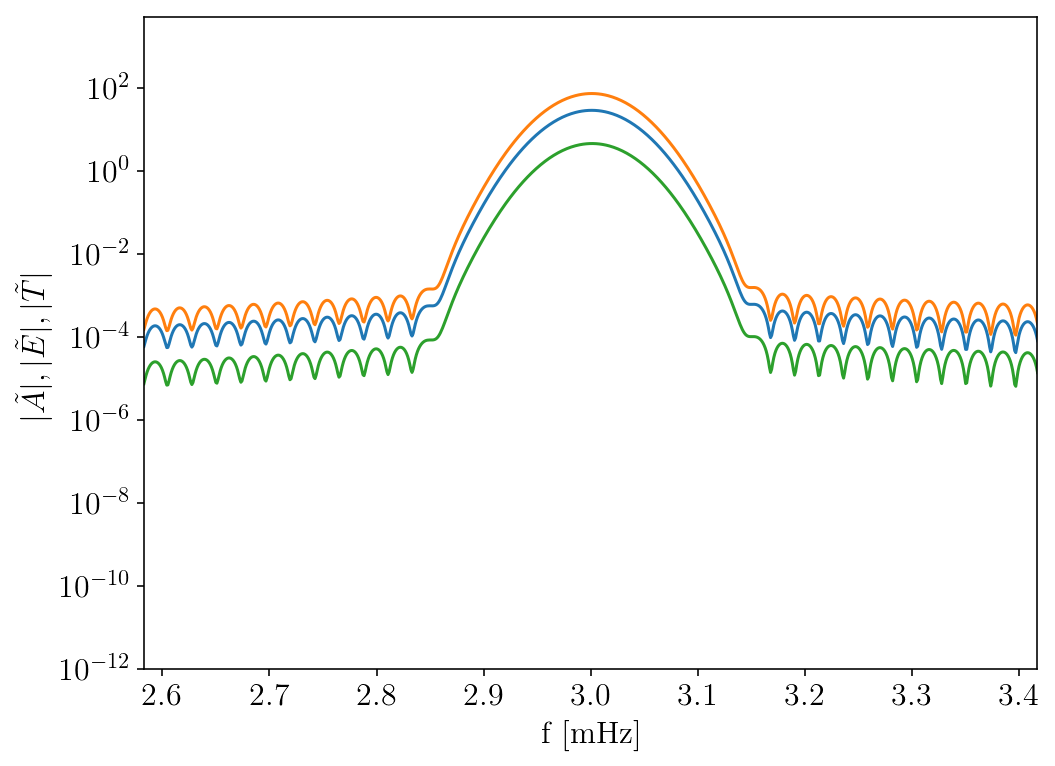

In [16]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_xlabel(r'f [mHz]',fontsize=16)
ax.set_ylabel(r'$|\tilde{A}|,|\tilde{E}|,|\tilde{T}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(gw.hp_wavelet.f_min*mult, gw.hp_wavelet.f_max*mult)

ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.A))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.E))
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.T))

plt.ylim(1.0e-12, 5.0e3)

plt.show()

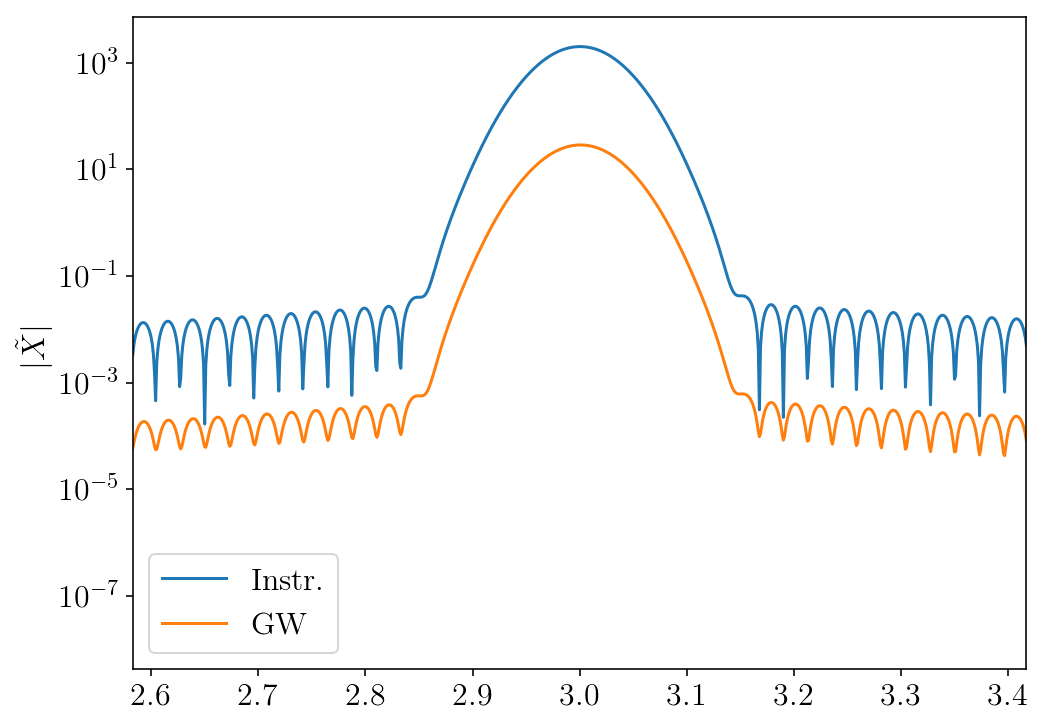

In [17]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax.set_ylabel(r'$|\tilde{X}|$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

mult = 1000.
plt.xlim(wave.f_min*mult, wave.f_max*mult)

ax.semilogy(tdi.freqs*mult, np.abs(tdi.X), label=r'Instr.')
ax.semilogy(tdi_GW.freqs*mult, np.abs(tdi_GW.X), label=r'GW')

ax.legend(loc='lower left',fontsize=16)

plt.show()

In [18]:
mask = (tdi.freqs>1.0e-3) & (tdi.freqs<5.0e-3)
noise = orb.get_Sn(tdi.freqs[mask])

In [19]:
snr_GW_X = 4.0*np.sum( tdi_GW.X[mask]*np.conjugate(tdi_GW.X[mask])/noise).real/gw.N/orb.dt
print snr_GW_X

snr_GW_Y = 4.0*np.sum( tdi_GW.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise).real/gw.N/orb.dt
print snr_GW_Y

snr_GW_Z = 4.0*np.sum( tdi_GW.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise).real/gw.N/orb.dt
print snr_GW_Z

6.94603026928e+41
2.06969731118e+42
4.96724089723e+42


In [20]:
snr_GW = snr_GW_X + snr_GW_Y + snr_GW_Z
print np.sqrt(snr_GW)

2.78056491299e+21


In [21]:
snr_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi.X[mask])/noise).real/gw.N/orb.dt
print snr_X

snr_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi.Y[mask])/noise).real/gw.N/orb.dt
print snr_Y

snr_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi.Z[mask])/noise).real/gw.N/orb.dt
print snr_Z

3.38879075634e+45
3.38879075634e+45
0.0


In [22]:
snr = snr_X + snr_Y + snr_Z
print np.sqrt(snr)

8.23260682449e+22


In [23]:
overlap_X = 4.0*np.sum( tdi.X[mask]*np.conjugate(tdi_GW.X[mask])/noise ).real/gw.N/orb.dt
print overlap_X/np.sqrt(snr*snr_GW)

overlap_Y = 4.0*np.sum( tdi.Y[mask]*np.conjugate(tdi_GW.Y[mask])/noise ).real/gw.N/orb.dt
print overlap_Y/np.sqrt(snr*snr_GW)

overlap_Z = 4.0*np.sum( tdi.Z[mask]*np.conjugate(tdi_GW.Z[mask])/noise ).real/gw.N/orb.dt
print overlap_Z/np.sqrt(snr*snr_GW)


0.137162878227
-0.227913382616
0.0


In [24]:
overlap = overlap_X + overlap_Y + overlap_Z

print overlap/np.sqrt(snr*snr_GW)

-0.0907505043897
